In [7]:
# Install pandas if needed (Google Colab has it preinstalled)
!pip install pandas scikit-learn matplotlib

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import io
import zipfile
import requests

# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"

# Fetch the content of the URL
response = requests.get(url)
response.raise_for_status()  # Raise an exception for bad responses

# Extract the 'SMSSpamCollection' file from the zip archive
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    with z.open('SMSSpamCollection') as f:
        df = pd.read_csv(f, sep='\t', names=['label', 'message'])

print(f"Loaded {len(df)} messages")
print(df.head())

Loaded 5572 messages
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [4]:
# Convert labels to 0 (ham) and 1 (spam)
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Create TF-IDF features
vectorizer = TfidfVectorizer(max_features=3000, stop_words='english')
X = vectorizer.fit_transform(df['message'])
y = df['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [5]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Get predicted probabilities
y_prob = model.predict_proba(X_test)[:, 1]  # Probability of being spam


Threshold: 0.30
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.99      0.89      0.94       149

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Confusion Matrix:
[[965   1]
 [ 17 132]]

Threshold: 0.50
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       966
           1       1.00      0.79      0.88       149

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.93      1115
weighted avg       0.97      0.97      0.97      1115

Confusion Matrix:
[[966   0]
 [ 31 118]]

Threshold: 0.70
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       966
           1       1.00      0.44      0.61       149

    accuracy                           0.93      

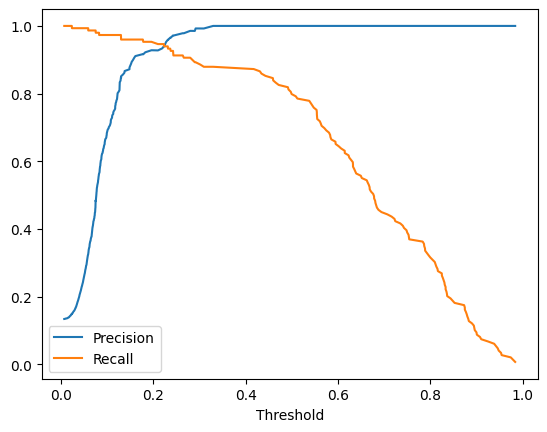

In [10]:
def evaluate_threshold(threshold):
    y_pred = (y_prob >= threshold).astype(int)
    print(f"\nThreshold: {threshold:.2f}")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

# Test thresholds
for thresh in [0.3, 0.5, 0.7]:
    evaluate_threshold(thresh)

# Plot precision-recall tradeoff
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.show()

In [11]:
def is_spam(text, threshold=0.5):
    # Transform input text
    text_vec = vectorizer.transform([text])
    prob_spam = model.predict_proba(text_vec)[0][1]

    # Decision based on threshold
    if prob_spam >= threshold:
        return f"SPAM ({prob_spam:.2%} confidence)"
    else:
        return f"NOT SPAM ({prob_spam:.2%} confidence)"

# Test examples
test_emails = [
    "Free iPhone! Click here to claim your prize!",
    "Hey, lunch tomorrow at 12?",
    "Your package will arrive Thursday",
    "Congratulations! You've won $10,000!"
]

print("\nTesting Classifier:")
for msg in test_emails:
    print(f"\n'{msg[:30]}...' => {is_spam(msg)}")


Testing Classifier:

'Free iPhone! Click here to cla...' => SPAM (78.82% confidence)

'Hey, lunch tomorrow at 12?...' => NOT SPAM (4.50% confidence)

'Your package will arrive Thurs...' => NOT SPAM (8.27% confidence)

'Congratulations! You've won $1...' => NOT SPAM (34.17% confidence)
